In [1]:
import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt

In [3]:
# Función para remover acentos y estandarizar nombres
def normalizar_nombre(nombre):
    return ''.join(c for c in unicodedata.normalize('NFKD', nombre) if not unicodedata.combining(c))

In [4]:
# Cargar datos
posiciones_path = "C:/temp/Projects/Tabla_posiciones.csv"
partidos_path = "C:/temp/Projects/PartidosFaltantes.csv"

In [6]:
tabla_posiciones = pd.read_csv(posiciones_path, encoding="latin1")
partidos_faltantes = pd.read_csv(partidos_path, encoding="latin1")

In [28]:
print(partidos_faltantes)


    Jornada      Local    Visitor LocalID VisitorID  LocalGol  VisGol
0        15   Paraguay  Venezuela     PAR       VEN       NaN     NaN
1        15     Brasil    Bolivia     BRA       BOL       NaN     NaN
2        15    Ecuador  Argentina     ECU       ARG       NaN     NaN
3        15       Peru   Colombia     PER       COL       NaN     NaN
4        15    Uruguay      Chile     URU       CHI       NaN     NaN
5        16  Venezuela    Bolivia     VEN       BOL       NaN     NaN
6        16   Colombia   Paraguay     COL       PAR       NaN     NaN
7        16  Argentina     Brasil     ARG       BRA       NaN     NaN
8        16      Chile       Peru     CHI       PER       NaN     NaN
9        16    Uruguay    Ecuador     URU       ECU       NaN     NaN
10       17    Bolivia   Colombia     BOL       COL       NaN     NaN
11       17   Paraguay  Argentina     PAR       ARG       NaN     NaN
12       17     Brasil      Chile     BRA       CHI       NaN     NaN
13       17       Pe

In [14]:
# Normalizar nombres de equipos
tabla_posiciones["Country"] = tabla_posiciones["Country"].apply(normalizar_nombre)
partidos_faltantes["Local"] = partidos_faltantes["Local"].apply(normalizar_nombre)
partidos_faltantes["Visitor"] = partidos_faltantes["Visitor"].apply(normalizar_nombre)

In [15]:
# Extraer equipos y puntos actuales
equipos = tabla_posiciones["Country"].tolist()
puntos_actuales = dict(zip(tabla_posiciones["Country"], tabla_posiciones["PTS"]))

In [16]:
# Configuración de simulación
num_simulaciones = 30000
position_counts = {team: np.zeros(len(equipos)) for team in equipos}
classification_counts = {team: {"Clasificado": 0, "Repechaje": 0, "Eliminado": 0} for team in equipos}

In [17]:
# Función para determinar el resultado de un partido
def determinar_resultado():
    goles_local = np.random.choice([0, 1, 2, 3, 4, 5])
    goles_visitante = np.random.choice([0, 1, 2, 3, 4, 5])
    if goles_local > goles_visitante:
        return "L", 3, 0  # Local gana
    elif goles_local < goles_visitante:
        return "V", 0, 3  # Visitante gana
    else:
        return "E", 1, 1  # Empate

In [18]:
# Simulación de Montecarlo
for _ in range(num_simulaciones):
    simulated_points = puntos_actuales.copy()
    
    for _, partido in partidos_faltantes.iterrows():
        local, visitante = partido["Local"], partido["Visitor"]
        _, puntos_local, puntos_visitante = determinar_resultado()
        
        simulated_points[local] += puntos_local
        simulated_points[visitante] += puntos_visitante
    
    # Ordenar por puntos
    sorted_teams = sorted(simulated_points.items(), key=lambda x: x[1], reverse=True)
    
    for rank, (team, _) in enumerate(sorted_teams):
        position_counts[team][rank] += 1
        
        # Clasificación
        if rank < 6:
            classification_counts[team]["Clasificado"] += 1
        elif rank == 6:
            classification_counts[team]["Repechaje"] += 1
        else:
            classification_counts[team]["Eliminado"] += 1
 

In [21]:
# Convertir a probabilidades
position_probs = {team: counts / num_simulaciones for team, counts in position_counts.items()}
classification_probs = {team: {key: value / num_simulaciones for key, value in counts.items()} for team, counts in classification_counts.items()}

df_probs = pd.DataFrame(position_probs, index=[f"Pos {i+1}" for i in range(len(equipos))]).T
df_classification = pd.DataFrame(classification_probs).T

In [22]:
# Mostrar resultados en porcentaje
print(df_probs * 100)
print(df_classification * 100)


               Pos 1      Pos 2      Pos 3      Pos 4      Pos 5      Pos 6  \
Argentina  96.423333   3.240000   0.330000   0.006667   0.000000   0.000000   
Ecuador     2.483333  43.863333  21.833333  15.466667  10.960000   4.830000   
Uruguay     0.273333  21.130000  18.553333  21.133333  20.970000  13.230000   
Brasil      0.380000  12.890000  23.840000  21.606667  20.186667  15.776667   
Paraguay    0.380000  11.853333  20.410000  22.163333  20.836667  18.433333   
Colombia    0.060000   7.006667  14.506667  16.840000  20.666667  29.416667   
Venezuela   0.000000   0.013333   0.373333   1.873333   4.140000  10.543333   
Bolivia     0.000000   0.003333   0.153333   0.910000   2.220000   7.033333   
Peru        0.000000   0.000000   0.000000   0.000000   0.006667   0.380000   
Chile       0.000000   0.000000   0.000000   0.000000   0.013333   0.356667   

               Pos 7      Pos 8      Pos 9     Pos 10  
Argentina   0.000000   0.000000   0.000000   0.000000  
Ecuador     0.5600

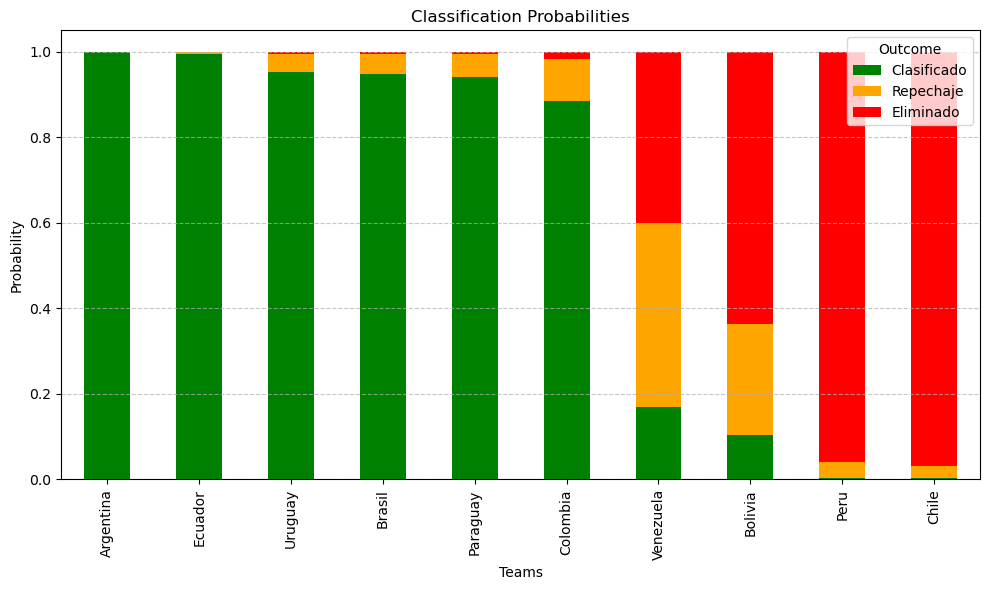

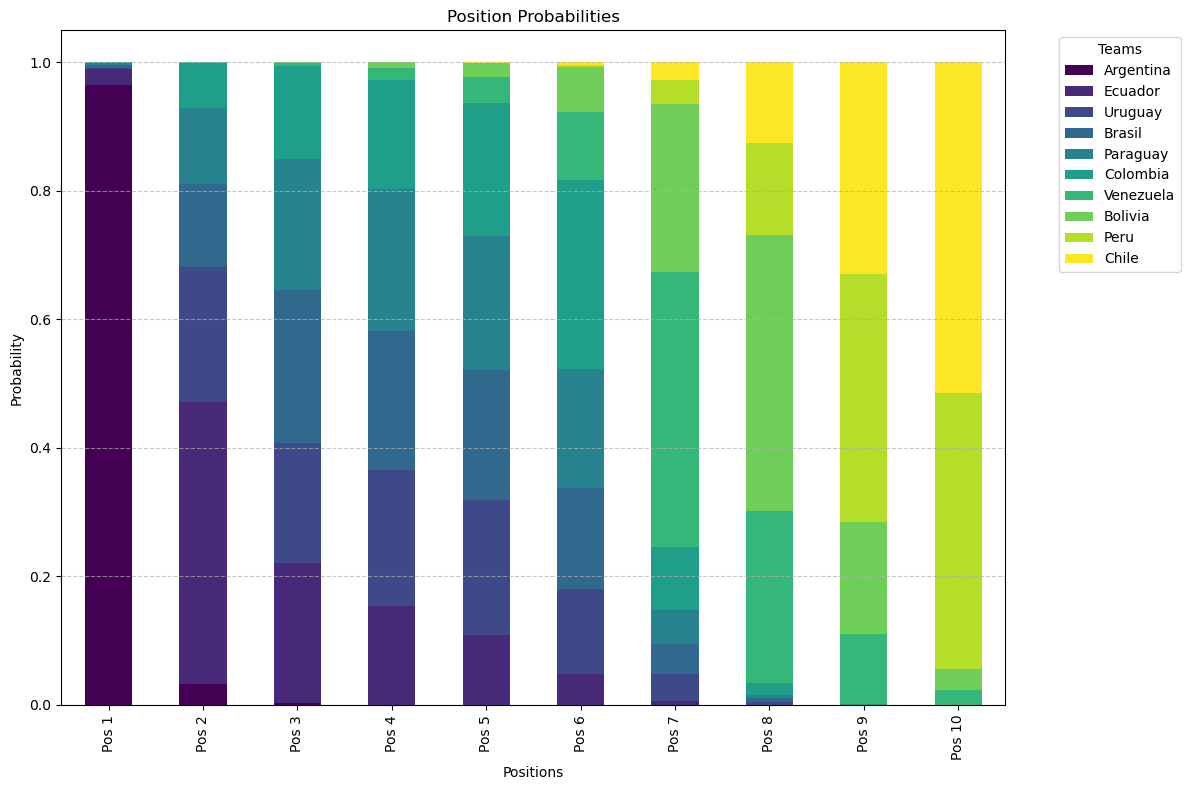

In [23]:
# Bar plot for classification probabilities
df_classification.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'orange', 'red'])
plt.title('Classification Probabilities')
plt.ylabel('Probability')
plt.xlabel('Teams')
plt.legend(title='Outcome', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar plot for position probabilities
df_probs.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Position Probabilities')
plt.ylabel('Probability')
plt.xlabel('Positions')
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()